In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
plt.style.use('ggplot')


# Opening GeoJSONs and exploring data

### Zoning data

In [4]:
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')
zones_geodata = zones_geodata.set_index(zones_geodata.columns[0])
zones_geodata.head()

,GEN_ZONE,ZN_ZONE,ZN_HOLDING,HOLDING_ID,FRONTAGE,ZN_AREA,UNITS,DENSITY,COVERAGE,FSI_TOTAL,...,ZN_EXCPTN,EXCPTN_NO,STAND_SET,ZN_STATUS,ZN_STRING,AREA_UNITS,ZBL_CHAPT,ZBL_SECTN,ZBL_EXCPTN,geometry
_id,,,,,,,,,,,,,,,,,,,,,
1,2,UT,N,0,-1.0,-1,-1,-1.0,0.0,-1.0,...,N,0,-1,2,UT,-1.0,100,100.10,,"MULTIPOLYGON (((-79.2097 43.81729, -79.20961 4..."
2,1,ON,N,0,-1.0,-1,-1,-1.0,0.0,-1.0,...,N,0,-1,0,ON,-1.0,90,90.20,,"MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ..."
3,0,RD,N,0,14.0,510,0,0.0,0.0,-1.0,...,Y,1058,-1,2,RD (f14.0; a510) (x1058),0.0,10,10.20,900.3.10(1058),"MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ..."
4,1,O,N,0,-1.0,-1,-1,-1.0,0.0,-1.0,...,N,0,-1,3,O,-1.0,90,90.10,,"MULTIPOLYGON (((-79.5704 43.72175, -79.57042 4..."
5,0,RD,N,0,0.0,0,0,0.0,0.0,-1.0,...,Y,1040,-1,2,RD (x1040),0.0,10,10.20,900.3.10(1040),"MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ..."


From the description of data: 

**ZN_ZONE**

The land use category of the lands within the zone boundary. Each 'zone category' has its own Chapter in the text of By-law 569-2013. Zoned destination of the zone limited by GEN_ZONE. 
- 0 = Residential 
- 1 = Open Space 
- 2 = Utility and Transportation 
- 4 = Employment Industrial 
- 5 = Institutional 
- 6 = Commercial Residential Employment 
- 101 = Residential Apartment 
- 201 = Commercial 
- 202 = Commercial Residential

In [5]:
zones_geodata.GEN_ZONE.unique()

array([  2,   1,   0,   4, 201, 202, 101,   6,   5])

In [6]:
# Only keep zoning type, and geometry, rest is not relevant
zones_geodata_cleaned = zones_geodata[['GEN_ZONE', 'geometry']]

# Rename 'GEN_ZONE' to 'Zone_type'
zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define the mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utility and Transportation', 
                4: 'Employment Industrial', 5: 'Institutional',
                6: 'Commercial Residential Employment', 101: 'Residential Apartment', 
                201: 'Commercial', 202: 'Commercial Residential'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata_cleaned['Zone_type'] = zones_geodata_cleaned['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata_cleaned.head()


C:\Users\aaron\AppData\Local\Temp\ipykernel_24544\1307462323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zones_geodata_cleaned.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)
c:\Users\aaron\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Zone_type,geometry
_id,,
1,Utility and Transportation,"MULTIPOLYGON (((-79.2097 43.81729, -79.20961 4..."
2,Open Space,"MULTIPOLYGON (((-79.50273 43.70976, -79.50195 ..."
3,Residential,"MULTIPOLYGON (((-79.27433 43.80068, -79.27425 ..."
4,Open Space,"MULTIPOLYGON (((-79.5704 43.72175, -79.57042 4..."
5,Residential,"MULTIPOLYGON (((-79.26202 43.81195, -79.26214 ..."


In [7]:
zones_geodata_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

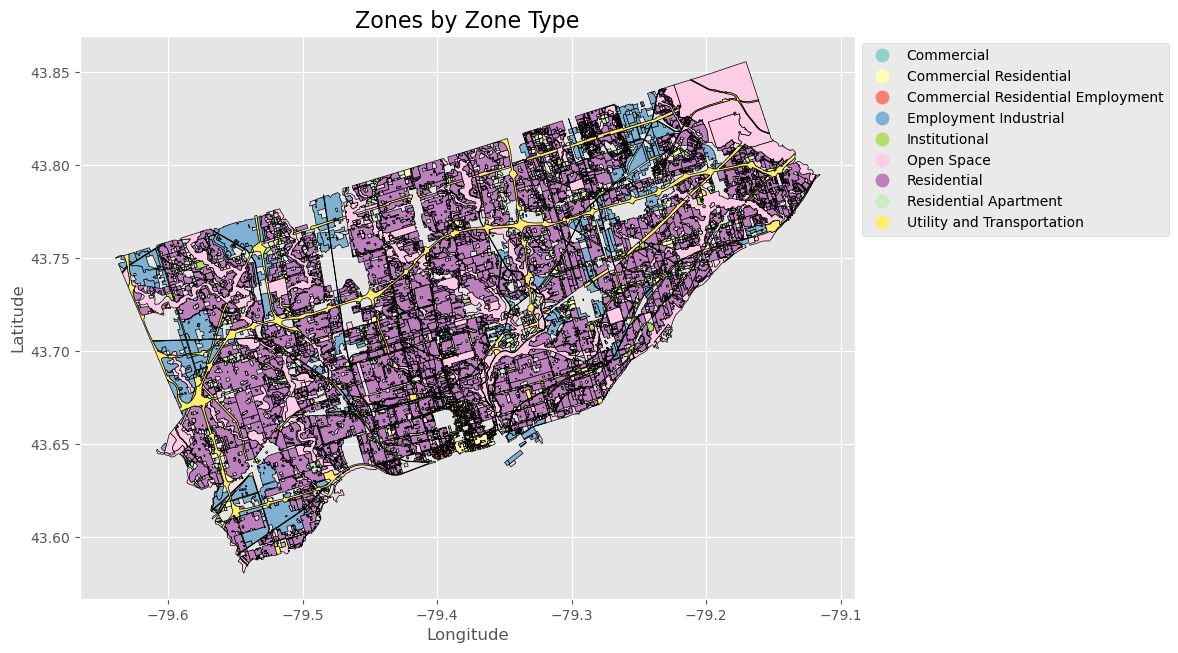

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
zones_geodata_cleaned.plot(column='Zone_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='Set3', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()

c:\Users\aaron\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


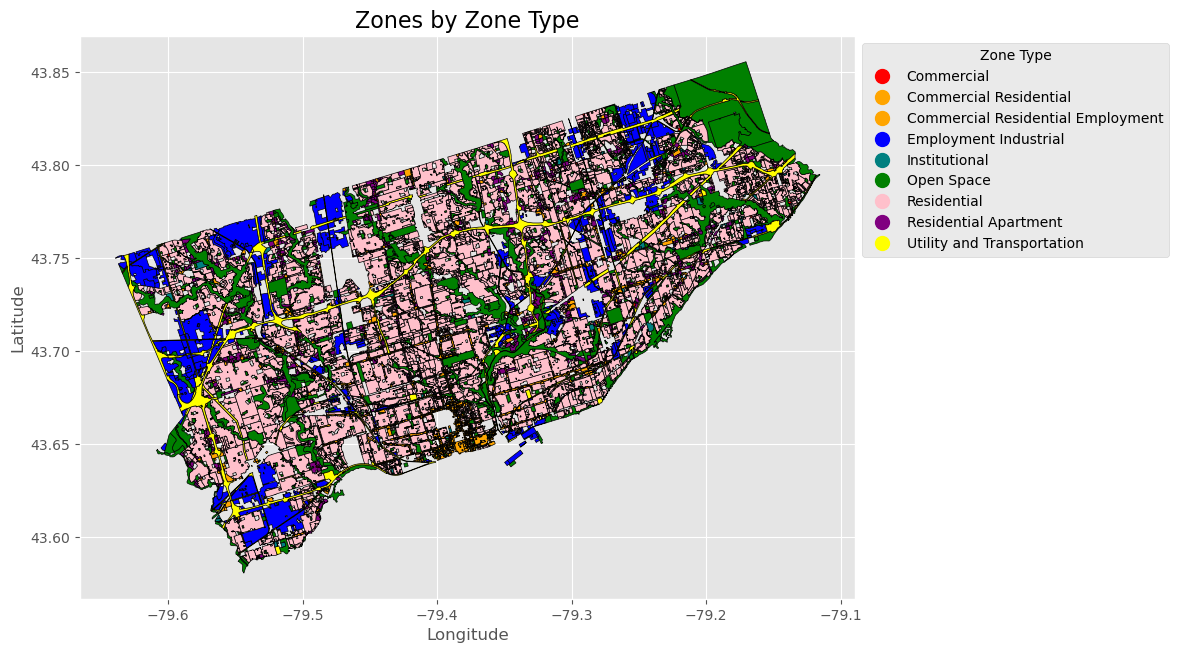

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a dictionary for the specific colors for each Zone_type
custom_colors = {
    'Commercial': 'red',
    'Commercial Residential': 'orange',
    'Commercial Residential Employment': 'orange',
    'Employment Industrial': 'blue',
    'Institutional': 'teal',
    'Open Space': 'green',
    'Residential': 'pink',
    'Residential Apartment': 'purple',
    'Utility and Transportation': 'yellow'
}

# Map Zone_type to colors
zones_geodata_cleaned['color'] = zones_geodata_cleaned['Zone_type'].map(custom_colors)

# Create a custom legend manually
legend_labels = list(custom_colors.keys())
legend_colors = [custom_colors[label] for label in legend_labels]

# Plot with the custom colors
fig, ax = plt.subplots(figsize=(10, 8))
zones_geodata_cleaned.plot(color=zones_geodata_cleaned['color'], ax=ax, edgecolor='black')

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10, linestyle='') 
           for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=handles, title='Zone Type', bbox_to_anchor=(1, 1), loc='upper left')

# Add labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Zones by Zone Type', fontsize=16)

# Display the plot
plt.show()


### Greenspace data

In [10]:
greenspace = gpd.read_file('Green Spaces - 4326.geojson')
greenspace = greenspace.set_index(greenspace.columns[0])
greenspace.head()

,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_CLASS_ID,AREA_CLASS,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,OBJECTID,geometry
_id,,,,,,,,,,,
1,1,1,0,890.0,OTHER_CEMETERY,None,4009,ARMADALE FREE METHODIST CEMETERY,ARMADALE FREE METHODIST CEMETERY,1.0,"MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ..."
2,2,2,0,890.0,OTHER_CEMETERY,None,4010,HILLSIDE CEMETERY,HILLSIDE CEMETERY,2.0,"MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ..."
3,3,3,0,890.0,OTHER_CEMETERY,None,4011,HIGHLAND MEMORY GARDENS,HIGHLAND MEMORY GARDENS,3.0,"MULTIPOLYGON (((-79.34758 43.8081, -79.34758 4..."
4,4,4,0,890.0,OTHER_CEMETERY,None,4005,CHRISTIE'S METHODIST CEMETERY,CHRISTIE'S METHODIST CEMETERY,4.0,"MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ..."
5,5,5,0,890.0,OTHER_CEMETERY,None,4012,ST. PAUL'S ANGLICAN CHURCH CEMETERY,ST. PAUL'S ANGLICAN CHURCH CEMETERY,5.0,"MULTIPOLYGON (((-79.31649 43.7964, -79.3165 43..."


In [11]:
greenspace.columns.unique()

Index(['AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'OBJECTID', 'geometry'],
      dtype='object')

In [12]:
greenspace_cleaned = greenspace[['AREA_CLASS', 'geometry']]
greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace_cleaned.head()


C:\Users\aaron\AppData\Local\Temp\ipykernel_24544\3715004460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greenspace_cleaned.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)


,Area_type,geometry
_id,,
1,OTHER_CEMETERY,"MULTIPOLYGON (((-79.25752 43.82953, -79.25739 ..."
2,OTHER_CEMETERY,"MULTIPOLYGON (((-79.18962 43.82488, -79.18949 ..."
3,OTHER_CEMETERY,"MULTIPOLYGON (((-79.34758 43.8081, -79.34758 4..."
4,OTHER_CEMETERY,"MULTIPOLYGON (((-79.31835 43.79902, -79.31851 ..."
5,OTHER_CEMETERY,"MULTIPOLYGON (((-79.31649 43.7964, -79.3165 43..."


In [13]:
greenspace_cleaned.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

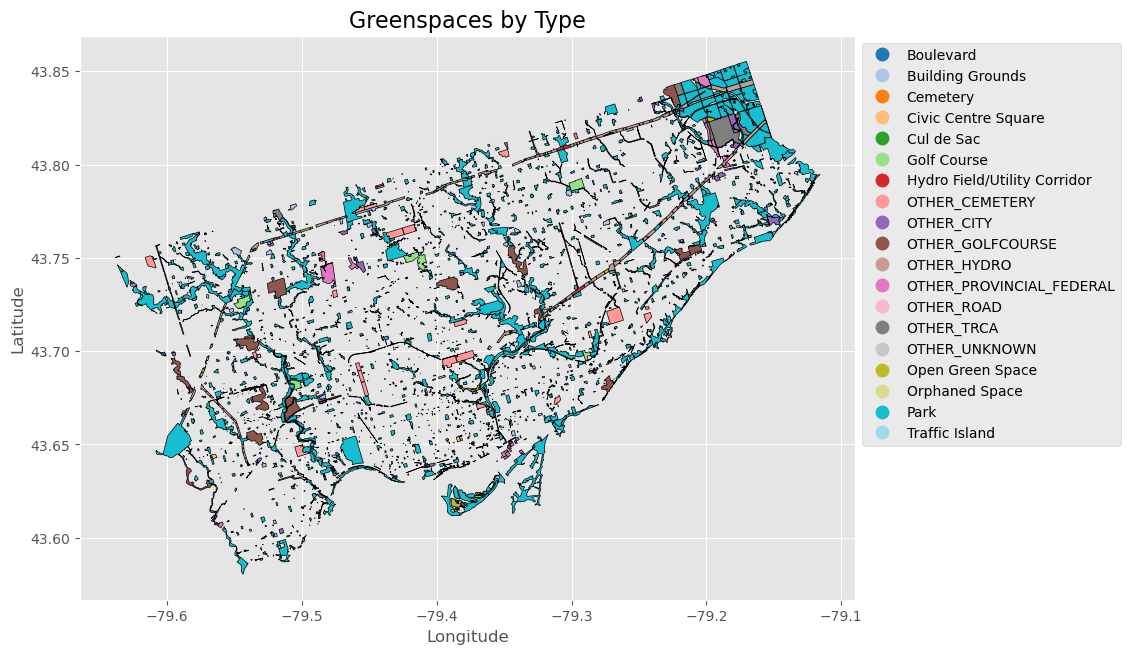

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with categorical coloring based on 'Zone_type'
greenspace_cleaned.plot(column='Area_type', ax=ax, legend=True, 
                           legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                           cmap='tab20', edgecolor='black')

# Add labels
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Greenspaces by Type', fontsize=16)

# Display the plot
plt.show()

### Flood plains data

In [15]:
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])
flood_plains.head()


,FloodPlain,Watershed,Shape__Are,Shape__Len,geometry
OBJECTID,,,,,
3394,Engineered,Don River,0.940918,3.803569,"MULTIPOLYGON (((-79.36482 43.67112, -79.36482 ..."
3395,Engineered,Don River,869.856689,149.201240,"MULTIPOLYGON (((-79.38004 43.67332, -79.38004 ..."
3396,Engineered,Don River,23187.910400,1321.226703,"MULTIPOLYGON (((-79.37672 43.6735, -79.37671 4..."
3397,Engineered,Don River,10895.613037,522.001575,"MULTIPOLYGON (((-79.3784 43.67362, -79.3784 43..."
3406,Engineered,Humber River,0.544922,5.605709,"MULTIPOLYGON (((-79.5036 43.71073, -79.5036 43..."


In [16]:
flood_plains.crs #check crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

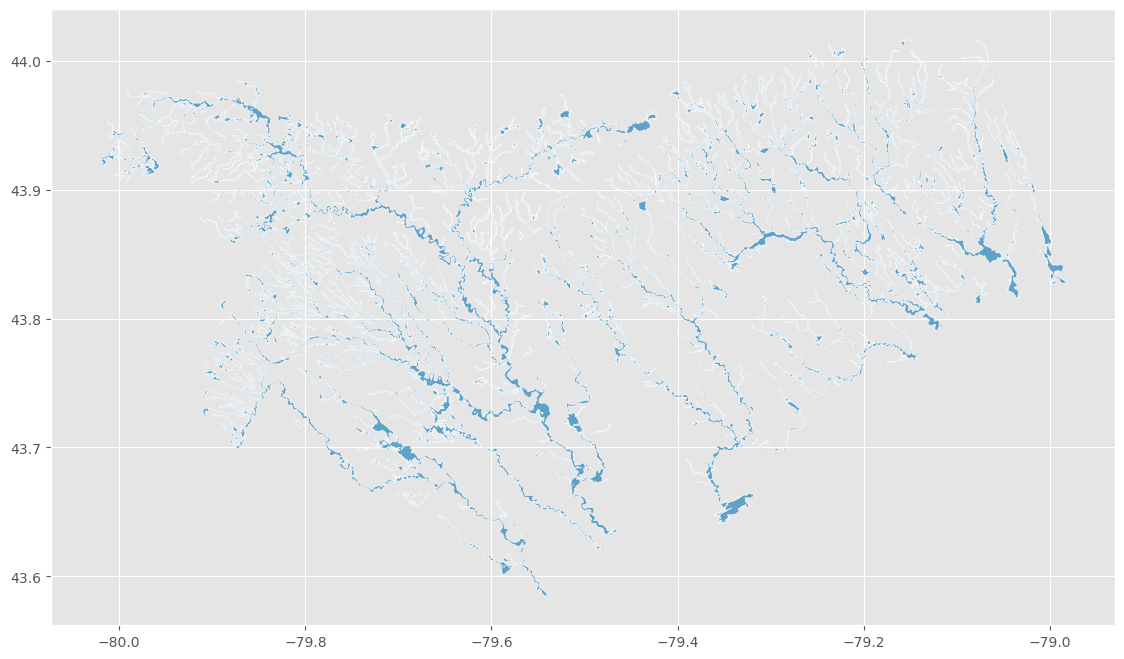

In [17]:
# Test plotting
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Neighbourhood data

In [18]:
neighbourhoods_geodata = gpd.read_file('Neighbourhoods - 4326.geojson')
neighbourhoods_geodata.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ..."


In [19]:
keep_columns = ['AREA_NAME', 'geometry']                                                #define columns to keep
neighbourhoods_geodata = neighbourhoods_geodata.filter(items=keep_columns)                            #filter df by columns
neighbourhoods_geodata.columns = ['Neighbourhood Name', 'geometry']                                         #rename columns
neighbourhoods_geodata = neighbourhoods_geodata.set_index(neighbourhoods_geodata.columns[0])

# View GeoDataFrame
neighbourhoods_geodata.head()

,geometry
Neighbourhood Name,
South Eglinton-Davisville,"MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ..."
North Toronto,"MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ..."
Dovercourt Village,"MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ..."
Junction-Wallace Emerson,"MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4..."
Yonge-Bay Corridor,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ..."


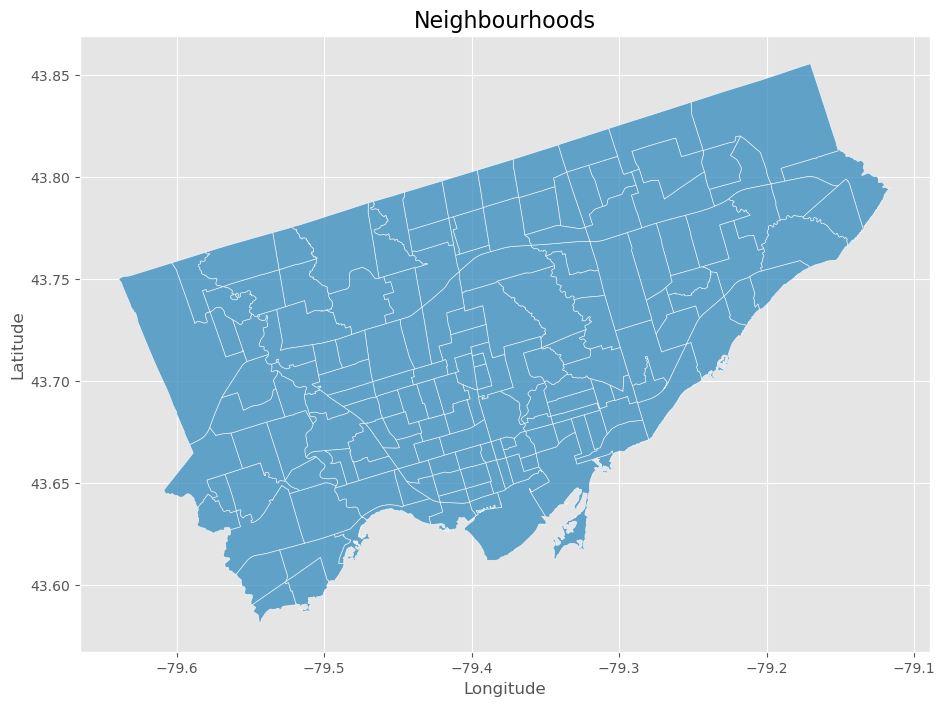

In [20]:
neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add title
plt.title('Neighbourhoods', fontsize=16)

# Display the plot
plt.show()

### Demographics Data

In [21]:
# Read the .xlsx file into a pandas DataFrame
neighbourhood_demographics = pd.read_excel("neighbourhood-profiles-2021-158-model.xlsx", engine="openpyxl")

# Print the DataFrame
neighbourhood_demographics.head()

,Neighbourhood Name,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Thistletown-Beaumond Heights,Rexdale-Kipling,Elms-Old Rexdale,Kingsview Village-The Westway,Willowridge-Martingrove-Richview,Humber Heights-Westmount,Edenbridge-Humber Valley,...,Harbourfront-CityPlace,St Lawrence-East Bayfront-The Islands,Church-Wellesley,Downtown Yonge East,Bay-Cloverhill,Yonge-Bay Corridor,Junction-Wallace Emerson,Dovercourt Village,North Toronto,South Eglinton-Davisville
0,Neighbourhood Number,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
1,TSNS 2020 Designation,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,...,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood
2,Total - Age groups of the population - 25% sam...,33300,31345,9850,10375,9355,22005,22445,10005,15190,...,28135,31285,22320,17700,16670,12645,23180,12380,15885,22735
3,0 to 14 years,4295,5690,1495,1575,1610,3915,3500,1370,2070,...,2065,2285,895,1055,745,970,3075,1365,1315,2190
4,0 to 4 years,1460,1650,505,505,440,1245,1065,395,520,...,1030,1045,495,480,370,500,1135,445,535,910


In [22]:
neighbourhood_demographics = neighbourhood_demographics.set_index(neighbourhood_demographics.columns[0])
neighbourhood_demographics.head()

,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Thistletown-Beaumond Heights,Rexdale-Kipling,Elms-Old Rexdale,Kingsview Village-The Westway,Willowridge-Martingrove-Richview,Humber Heights-Westmount,Edenbridge-Humber Valley,Princess-Rosethorn,...,Harbourfront-CityPlace,St Lawrence-East Bayfront-The Islands,Church-Wellesley,Downtown Yonge East,Bay-Cloverhill,Yonge-Bay Corridor,Junction-Wallace Emerson,Dovercourt Village,North Toronto,South Eglinton-Davisville
Neighbourhood Name,,,,,,,,,,,,,,,,,,,,,
Neighbourhood Number,1,2,3,4,5,6,7,8,9,10,...,165,166,167,168,169,170,171,172,173,174
TSNS 2020 Designation,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,...,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood
Total - Age groups of the population - 25% sample data,33300,31345,9850,10375,9355,22005,22445,10005,15190,11170,...,28135,31285,22320,17700,16670,12645,23180,12380,15885,22735
0 to 14 years,4295,5690,1495,1575,1610,3915,3500,1370,2070,1750,...,2065,2285,895,1055,745,970,3075,1365,1315,2190
0 to 4 years,1460,1650,505,505,440,1245,1065,395,520,545,...,1030,1045,495,480,370,500,1135,445,535,910


In [23]:
len(neighbourhood_demographics.columns.tolist())


158

In [24]:
neighbourhood_demographics_transpose = neighbourhood_demographics.T
neighbourhood_demographics_transpose.head()

Neighbourhood Name,Neighbourhood Number,TSNS 2020 Designation,Total - Age groups of the population - 25% sample data,0 to 14 years,0 to 4 years,5 to 9 years,10 to 14 years,15 to 64 years,15 to 19 years,20 to 24 years,...,Between 9 a.m. and 11:59 a.m.,Between 12 p.m. and 4:59 a.m.,Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data,Children eligible for instruction in the minority official language,Children not eligible for instruction in the minority official language,"Total - Eligibility and instruction in the minority official language, for the population in private households born between 2003 and 2015 (inclusive) - 25% sample data",Children eligible for instruction in the minority official language,Eligible children who have been instructed in the minority official language at the primary or secondary level in Canada,Eligible children who have not been instructed in the minority official language at the primary or secondary level in Canada,Children not eligible for instruction in the minority official language
West Humber-Clairville,1,Not an NIA or Emerging Neighbourhood,33300,4295,1460,1345,1485,23640,1860,3175,...,1665,2935,5430,410,5020,3875,335,255,75,3540
Mount Olive-Silverstone-Jamestown,2,Neighbourhood Improvement Area,31345,5690,1650,1860,2175,21490,2280,2675,...,1145,2965,7285,510,6780,5540,395,245,145,5145
Thistletown-Beaumond Heights,3,Neighbourhood Improvement Area,9850,1495,505,540,455,6615,570,745,...,395,635,1860,180,1685,1325,120,75,45,1205
Rexdale-Kipling,4,Not an NIA or Emerging Neighbourhood,10375,1575,505,615,455,6950,515,715,...,425,775,1910,135,1770,1370,90,75,25,1275
Elms-Old Rexdale,5,Neighbourhood Improvement Area,9355,1610,440,480,685,6355,635,685,...,355,675,2015,95,1920,1520,70,60,10,1445


In [25]:
neighbourhood_demographics_transpose.shape

(158, 2603)

### Combining datasets 

In [26]:
merged_neighbourhood_df = pd.merge(neighbourhood_demographics_transpose, neighbourhoods_geodata, left_index=True, right_index=True, how='inner')
merged_neighbourhood_df.head()

,Neighbourhood Number,TSNS 2020 Designation,Total - Age groups of the population - 25% sample data,0 to 14 years,0 to 4 years,5 to 9 years,10 to 14 years,15 to 64 years,15 to 19 years,20 to 24 years,...,Between 12 p.m. and 4:59 a.m.,Total - Eligibility for instruction in the minority official language for the population in private households born in 2003 or later - 25% sample data,Children eligible for instruction in the minority official language,Children not eligible for instruction in the minority official language,"Total - Eligibility and instruction in the minority official language, for the population in private households born between 2003 and 2015 (inclusive) - 25% sample data",Children eligible for instruction in the minority official language,Eligible children who have been instructed in the minority official language at the primary or secondary level in Canada,Eligible children who have not been instructed in the minority official language at the primary or secondary level in Canada,Children not eligible for instruction in the minority official language,geometry
West Humber-Clairville,1,Not an NIA or Emerging Neighbourhood,33300,4295,1460,1345,1485,23640,1860,3175,...,2935,5430,410,5020,3875,335,255,75,3540,"MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ..."
Mount Olive-Silverstone-Jamestown,2,Neighbourhood Improvement Area,31345,5690,1650,1860,2175,21490,2280,2675,...,2965,7285,510,6780,5540,395,245,145,5145,"MULTIPOLYGON (((-79.57938 43.76222, -79.57925 ..."
Thistletown-Beaumond Heights,3,Neighbourhood Improvement Area,9850,1495,505,540,455,6615,570,745,...,635,1860,180,1685,1325,120,75,45,1205,"MULTIPOLYGON (((-79.56226 43.74373, -79.56234 ..."
Rexdale-Kipling,4,Not an NIA or Emerging Neighbourhood,10375,1575,505,615,455,6950,515,715,...,775,1910,135,1770,1370,90,75,25,1275,"MULTIPOLYGON (((-79.56419 43.71229, -79.5667 4..."
Elms-Old Rexdale,5,Neighbourhood Improvement Area,9355,1610,440,480,685,6355,635,685,...,675,2015,95,1920,1520,70,60,10,1445,"MULTIPOLYGON (((-79.54677 43.73156, -79.54632 ..."


In [27]:
merged_neighbourhood_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, West Humber-Clairville to South Eglinton-Davisville
Columns: 2604 entries, Neighbourhood Number to geometry
dtypes: geometry(1), object(2603)
memory usage: 3.0+ MB


In [28]:
merged_neighbourhood_df.columns.tolist()

['Neighbourhood Number',
 'TSNS 2020 Designation',
 'Total - Age groups of the population - 25% sample data',
 '  0 to 14 years',
 '    0 to 4 years',
 '    5 to 9 years',
 '    10 to 14 years',
 '  15 to 64 years',
 '    15 to 19 years',
 '    20 to 24 years',
 '    25 to 29 years',
 '    30 to 34 years',
 '    35 to 39 years',
 '    40 to 44 years',
 '    45 to 49 years',
 '    50 to 54 years',
 '    55 to 59 years',
 '    60 to 64 years',
 '  65 years and over',
 '    65 to 69 years',
 '    70 to 74 years',
 '    75 to 79 years',
 '    80 to 84 years',
 '    85 years and over',
 '      85 to 89 years',
 '      90 to 94 years',
 '      95 to 99 years',
 '      100 years and over',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data',
 '  0 to 14 years',
 '  15 to 64 years',
 '  65 years and over',
 '    85 years and over',
 'Average age of the population',
 'Median age of the population',
 'Total - Persons in private households - 25% sample data',
 '  T

In [53]:
# Count occurrences of the column name in the DataFrame columns
column_name = '  $10,000 to $14,999'
count = merged_neighbourhood_df.columns.to_list().count(column_name)

print(f"The column '{column_name}' appears {count} times in merged_neighbourhood_df.")


The column '  $10,000 to $14,999' appears 2 times in merged_neighbourhood_df.


In [54]:
# Rename columns to include their column index
merged_neighbourhood_df.columns = [
    f"{col} ({i})" for i, col in enumerate(merged_neighbourhood_df.columns)
]

# Display the first few renamed columns to verify
print("Renamed columns:")
print(merged_neighbourhood_df.columns[:10])  # Display first 10 columns for verification


Renamed columns:
Index(['Neighbourhood Number (0)', 'TSNS 2020 Designation (1)',
       'Total - Age groups of the population - 25% sample data (2)',
       '  0 to 14 years (3)', '    0 to 4 years (4)', '    5 to 9 years (5)',
       '    10 to 14 years (6)', '  15 to 64 years (7)',
       '    15 to 19 years (8)', '    20 to 24 years (9)'],
      dtype='object')


In [55]:
merged_neighbourhood_df.columns.tolist()

['Neighbourhood Number (0)',
 'TSNS 2020 Designation (1)',
 'Total - Age groups of the population - 25% sample data (2)',
 '  0 to 14 years (3)',
 '    0 to 4 years (4)',
 '    5 to 9 years (5)',
 '    10 to 14 years (6)',
 '  15 to 64 years (7)',
 '    15 to 19 years (8)',
 '    20 to 24 years (9)',
 '    25 to 29 years (10)',
 '    30 to 34 years (11)',
 '    35 to 39 years (12)',
 '    40 to 44 years (13)',
 '    45 to 49 years (14)',
 '    50 to 54 years (15)',
 '    55 to 59 years (16)',
 '    60 to 64 years (17)',
 '  65 years and over (18)',
 '    65 to 69 years (19)',
 '    70 to 74 years (20)',
 '    75 to 79 years (21)',
 '    80 to 84 years (22)',
 '    85 years and over (23)',
 '      85 to 89 years (24)',
 '      90 to 94 years (25)',
 '      95 to 99 years (26)',
 '      100 years and over (27)',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data (28)',
 '  0 to 14 years (29)',
 '  15 to 64 years (30)',
 '  65 years and over (31)',
 '    85

Dataframe is now combined and ready for feature analysis

In [29]:
intersection = gpd.overlay(flood_line, neighbourhoods_geodata, how='intersection')

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the neighbourhoods
neighbourhoods_geodata.plot(ax=ax, edgecolor='w', alpha=0.75)

# Plot the flood line only if it intersects the neighbourhoods
if not intersection.empty:
    intersection.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains Intersection')

# Labeling the axes
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)

# Add title
plt.title('Flood Plains and Neighbourhoods', fontsize=20)

# Show the plot
plt.show()

NameError: name 'flood_line' is not defined

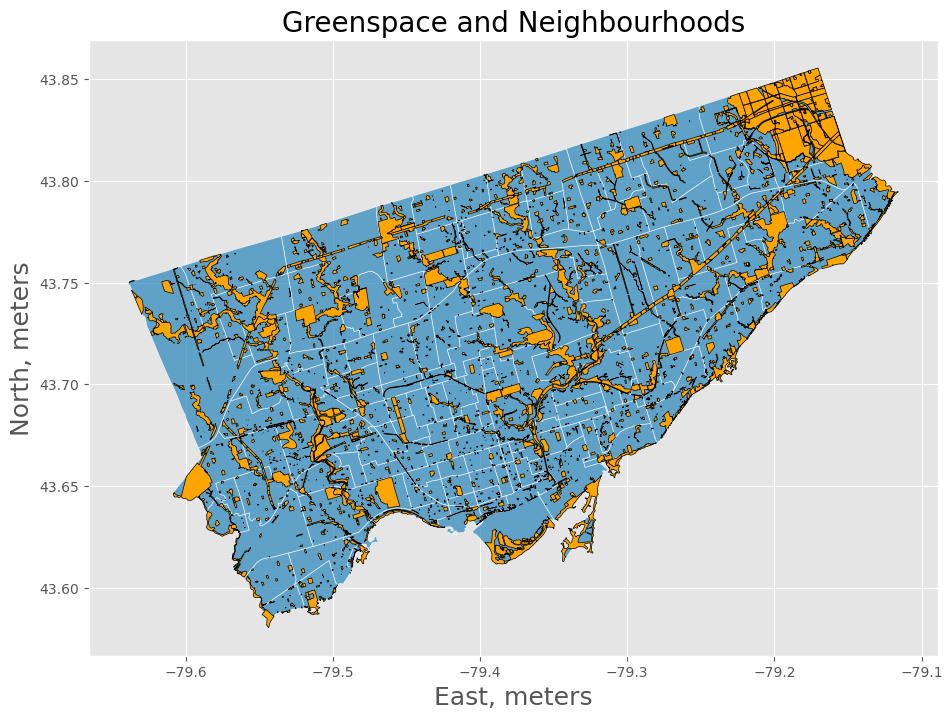

In [30]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
greenspace.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Greenspace and Neighbourhoods', fontsize=20)                          #title
plt.show()

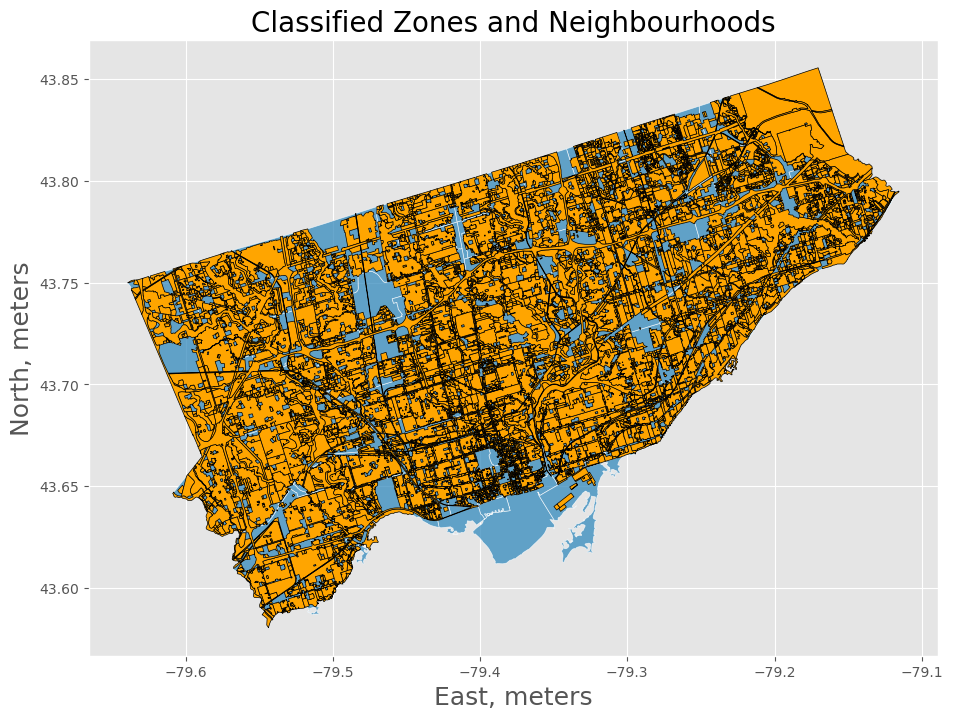

In [31]:
ax = neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)                       #plot size and colour
zones_geodata.plot(ax=ax, color='orange', edgecolor='k', label='Flood Plains')  
plt.xlabel('East, meters', fontsize=18)                                                    #axses labels
plt.ylabel('North, meters', fontsize=18) 
plt.title('Classified Zones and Neighbourhoods', fontsize=20)                          #title
plt.show()

c:\Users\aaron\anaconda3\Lib\site-packages\mapclassify\classifiers.py:462: RuntimeWarning: invalid value encountered in greater
  binIds += (x > _l) * (x <= r) * k
c:\Users\aaron\anaconda3\Lib\site-packages\mapclassify\classifiers.py:462: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > _l) * (x <= r) * k


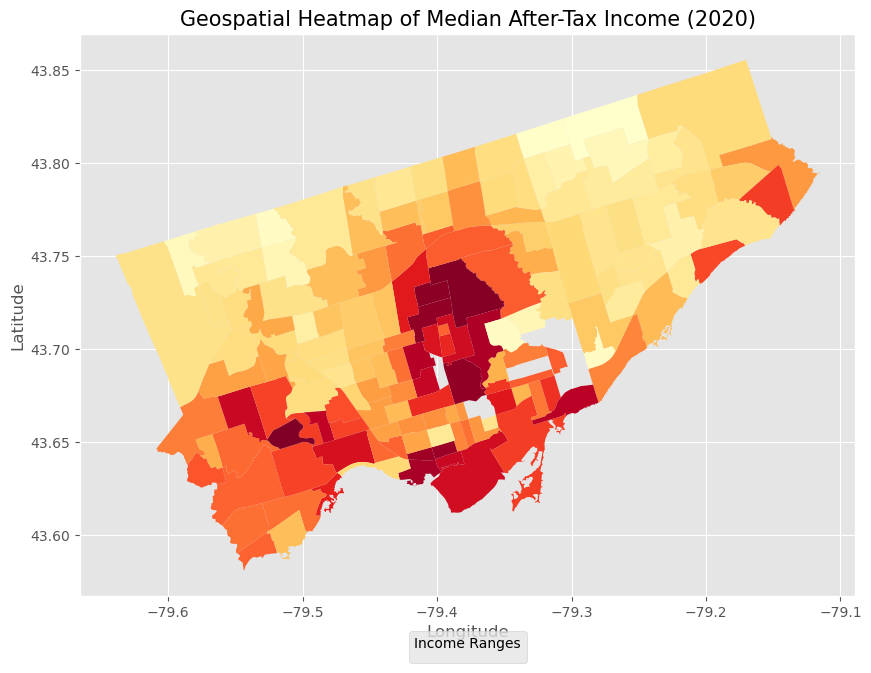

In [32]:
income_data = neighbourhood_demographics_transpose[["    Median total income in 2020  among recipients ($)"]]
merged_gdf = neighbourhoods_geodata.join(income_data)

classifier = mapclassify.Quantiles(merged_gdf["    Median total income in 2020  among recipients ($)"], k=4)
merged_gdf["income_bins"] = classifier.yb  # Add the classification to the GeoDataFrame


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with the selected income column for color mapping
merged_gdf.plot(column="    Median total income in 2020  among recipients ($)",
                ax=ax,
                cmap='YlOrRd',  # Choose the color map, e.g., 'viridis', 'coolwarm', etc.
                legend_kwds={
                    'label': "Median After-Tax Income ($)",  # Label for the legend
                    'orientation': "horizontal",  # Orientation of the legend
                    'bbox_to_anchor': (0.5, -0.05),  # Position the legend
                    'loc': 'upper center'  # Position legend in the center
                })

# Customize the legend
# Create a list of the bin labels based on the classification
bin_labels = [f"{round(classifier.bins[i], 2)} - {round(classifier.bins[i + 1], 2)}"
              for i in range(len(classifier.bins) - 1)]

# Add a legend with the appropriate bin ranges
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, bin_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Income Ranges")

# Add title and labels
ax.set_title("Geospatial Heatmap of Median After-Tax Income (2020)", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


Now we shall only retrieve the columns that pertain to the vulnerability index.

In [52]:
useful_neighbourhood_columns = merged_neighbourhood_df[
['Neighbourhood Number',
 'TSNS 2020 Designation',
 'geometry',
 # ################# AGE DATA ##########################
 'Total - Age groups of the population - 25% sample data',
 '  0 to 14 years',
 '  15 to 64 years',
 '  65 years and over',
 'Total - Distribution (%) of the population by broad age groups - 25% sample data',
 '  0 to 14 years',
 '  15 to 64 years',
 '  65 years and over',
 '    85 years and over',
 'Average age of the population',
 'Median age of the population',

 # ####################### FAMILY TYPE DATA ###################
 'Total - Persons in private households - 25% sample data',
 '  Total - Persons in census families',
 '    Married spouses or common-law partners',
 '    Parents in one-parent families',
 '    Children',
 '      In a two-parent family',
 '      In a one-parent family',
 '  Total - Persons not in census families in private households - 25% sample data',
 '    Living alone',
 '    Living with other relatives',
 '    Living with non-relatives only',
 'Number of persons in private households',
 'Total - Marital status for the total population aged 15 years and over - 25% sample data',
 '  Married or living common-law',
 '  Not married and not living common-law',

 # ###################### INCOME DATA ##########################
 'Total - Income statistics in 2020 for the population aged 15 years and over in private households - 25% sample data',
 '  Number of total income recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median total income in 2020  among recipients ($)',
 '    Average total income in 2020 among recipients ($)',
 '  Number of after-tax income recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median after-tax income in 2020 among recipients ($)',
 '    Average after-tax income in 2020 among recipients ($)',
 '  Number of market income recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median market income in 2020  among recipients ($)',
 '    Average market income in 2020 among recipients ($)',
 '  Number of employment income recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median employment income in 2020 among recipients ($)',
 '    Average employment income in 2020 among recipients ($)',
 '  Number of government transfers recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median government transfers in 2020 among recipients ($)',
 '    Average government transfers in 2020 among recipients ($)',
 '  Number of employment insurance benefits recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median employment insurance benefits in 2020 among recipients ($)',
 '    Average employment insurance benefits in 2020 among recipients ($)',
 '  Number of COVID-19 emergency and recovery benefits recipients aged 15 years and over in private households in 2020 - 25% sample data',
 '    Median COVID-19 emergency and recovery benefits in 2020 among recipients ($)',
 '    Average COVID-19 emergency and recovery benefits in 2020 among recipients ($)',
 'Composition of total income in 2020 of the population aged 15 years and over in private households (%) - 25% sample data',
 '  Market income (%)',
 '    Employment income (%)',
 '  Government transfers (%)',
 '    Employment insurance benefits (%)',
 '    COVID-19 - Government income support and benefits (%)',
 '      COVID-19 - Emergency and recovery benefits (%)',
 'Total - Total income groups in 2020 for the population aged 15 years and over in private households - 25% sample data',
 '  Without total income',
 '  With total income',
 '    Under $10,000 (including loss)',
 '    $10,000 to $19,999',
 '    $20,000 to $29,999',
 '    $30,000 to $39,999',
 '    $40,000 to $49,999',
 '    $50,000 to $59,999',
 '    $60,000 to $69,999',
 '    $70,000 to $79,999',
 '    $80,000 to $89,999',
 '    $90,000 to $99,999',
 '    $100,000 and over',
 '      $100,000 to $149,999',
 '      $150,000 and over',

 'Total - Income statistics in 2019 for the population aged 15 years and over in private households - 25% sample data',
 '  Number of total income recipients aged 15 years and over in private households in 2019 - 25% sample data',
 '    Median total income in 2019 among recipients ($)',
 '    Average total income in 2019 among recipients ($)',

 'Total - LIM low-income status in 2020 for the population in private households - 25% sample data',
 '  0 to 17 years',
 '    0 to 5 years',
 '  18 to 64 years',
 '  65 years and over',

 'Total - Inequality measures for the population in private households - 25% sample data',
 '  Gini index on adjusted household total income',
 '  Gini index on adjusted household market income',
 '  Gini index on adjusted household after-tax income',
 '  P90/P10 ratio on adjusted household after-tax income',
 'Total - Occupied private dwellings by structural type of dwelling - 25% sample data',
 '  Single-detached house',
 '  Semi-detached house',
 '  Row house',
 '  Apartment or flat in a duplex',
 '  Apartment in a building that has fewer than five storeys',
 '  Apartment in a building that has five or more storeys',
 '  Other single-attached house',
 '  Movable dwelling',
 'Total - Private households by household size - 25% sample data',
 '  1 person',
 '  2 persons',
 '  3 persons',
 '  4 persons',
 '  5 or more persons',
 'Average household size',
 'Total - Household type - 25% sample data',
 '  One-census-family households without additional persons',
 '    Couple-family households',
 '      With children',
 '      Without children',
 '    One-parent-family households',
 '  Multigenerational households',
 '  Multiple-census-family households',
 '  One-census-family households with additional persons',
 '  Two-or-more-person non-census-family households',
 '  One-person households',
 'Total - Income statistics for private households - 25% sample data',
 '  Median total income of household in 2020 ($)',
 '  Average total income of household in 2020 ($)',
 '  Median after-tax income of household in 2020 ($)',
 '  Average after-tax income of household in 2020 ($)',
 'Total - Income statistics for one-person private households - 25% sample data',
 '  Median total income of one-person households in 2020 ($)',
 '  Average total income of one-person households in 2020 ($)',
 '  Median after-tax income of one-person households in 2020 ($)',
 '  Average after-tax income of one-person households in 2020 ($)',
 'Total - Income statistics for two-or-more-persons private households - 25% sample data',
 '  Median total income of two-or-more-person households in 2020 ($)',
 '  Average total income of two-or-more-person households in 2020 ($)',
 '  Median after-tax income of two-or-more-person households in 2020 ($)',
 '  Average after-tax income of two-or-more-person households in 2020 ($)',
 'Total - Household total income groups in 2020 for private households - 25% sample data',
 '  Under $5,000',
 '  $5,000 to $9,999',
 '  $10,000 to $14,999',
 '  $15,000 to $19,999',
 '  $20,000 to $24,999',
 '  $25,000 to $29,999',
 '  $30,000 to $34,999',
 '  $35,000 to $39,999',
 '  $40,000 to $44,999',
 '  $45,000 to $49,999',
 '  $50,000 to $59,999',
 '  $60,000 to $69,999',
 '  $70,000 to $79,999',
 '  $80,000 to $89,999',
 '  $90,000 to $99,999',
 '  $100,000 and over',
 '    $100,000 to $124,999',
 '    $125,000 to $149,999',
 '    $150,000 to $199,999',
 '    $200,000 and over',
 # ######################### OWNERSHIP DATA ################
 'Total - Private households by tenure - 25% sample data',
 '  Owner',
 '  Renter',
 '  Dwelling provided by the local government, First Nation or Indian band',
 # ############### HOUSE TYPE DATA ############
 'Total - Occupied private dwellings by condominium status - 25% sample data',
 '  Condominium',
 '  Not condominium',
 'Total - Occupied private dwellings by number of rooms - 25% sample data',
 '  1 to 4 rooms',
 '  5 rooms',
 '  6 rooms',
 '  7 rooms',
 '  8 or more rooms',
 'Average number of rooms per dwelling',
 # ################HOUSING SUITABILITY #####################
 'Total - Private households by housing suitability - 25% sample data',
 '  Suitable',
 '  Not suitable',
 # ################### AGE OF HOUSES ###############
 'Total - Occupied private dwellings by period of construction - 25% sample data',
 '  1960 or before',
 '  1961 to 1980',
 '  1981 to 1990',
 '  1991 to 2000',
 '  2001 to 2005',
 '  2006 to 2010',
 '  2011 to 2015',
 '  2016 to 2021',
 'Total - Occupied private dwellings by dwelling condition - 25% sample data',
 '  Only regular maintenance and minor repairs needed',
 '  Major repairs needed',
 'Total - Private households by number of household maintainers - 25% sample data',
 '  One-maintainer household',
 '  Two-maintainer household',
 '  Three-or-more-maintainer household',

 'Total - Occupied private dwellings by housing indicators - 25% sample data',
 "  Total - Households 'spending 30% or more of income on shelter costs' or 'not suitable' or 'major repairs needed'",
 '    Spending 30% or more of income on shelter costs only',
 '    Not suitable only',
 '    Major repairs needed only',
 "    'Spending 30% or more of income on shelter costs' and 'not suitable'",
 "    'Spending 30% or more of income on shelter costs' and 'major repairs needed'",
 "    'Not suitable' and 'major repairs needed'",
 "    'Spending 30% or more of income on shelter costs' and 'not suitable' and 'major repairs needed'",
 '  Acceptable housing',
 'Total - Owner and tenant households with household total income greater than zero, in non-farm, non-reserve private dwellings by shelter-cost-to-income ratio - 25% sample data',
 '  Spending less than 30% of income on shelter costs',
 '  Spending 30% or more of income on shelter costs',
 '    30% to less than 100%',
 'Total - Owner and tenant households with household total income greater than zero and shelter-cost-to-income ratio less than 100%, in non-farm, non-reserve private dwellings by core housing need - 25% sample data',
 '  In core need',
 '  Not in core need',
 'Total - Owner households in non-farm, non-reserve private dwellings - 25% sample data',
 '  % of owner households with a mortgage',
 '  % of owner households spending 30% or more of its income on shelter costs',
 '  % in core housing need',
 '  Median monthly shelter costs for owned dwellings ($)',
 '  Average monthly shelter costs for owned dwellings ($)',
 '  Median value of dwellings ($)',
 '  Average value of dwellings ($)',
 'Total - Tenant households in non-farm, non-reserve private dwellings - 25% sample data',
 '  % of tenant households in subsidized housing',
 '  % of tenant households spending 30% or more of its income on shelter costs',
 '  % in core housing need',
 '  Median monthly shelter costs for rented dwellings ($)',
 '  Average monthly shelter costs for rented dwellings ($)',
 'Total - Households living in a dwelling provided by the local government, First Nation or Indian band in non-farm private dwellings - 25% sample data',
 '  % of households living in a dwelling provided by the local government, First Nation or Indian band spending more than 30% on shelter costs',
 '  Median monthly shelter costs for dwellings provided by local government, First Nation or Indian band ($)',
 '  Average monthly shelter costs for dwellings provided by local government, First Nation or Indian band ($)',
 'Total - Census families in private households by family size - 25% sample data',
 '  2 persons',
 '  3 persons',
 '  4 persons',
 '  5 or more persons',   
 'Average size of census families',
 'Total number of census families in private households - 25% sample data',
 '  Total couple families',
 '    Married couples',
 '      With children',
 '      Without children',
 '    Common-law couples',
 '      With children',
 '      Without children',
 '  Total one-parent families',
 '    in which the parent is a woman+',
 '    in which the parent is a man+',
 'Average number of children in census families with children'
]
]

useful_neighbourhood_columns.head()

,Neighbourhood Number,TSNS 2020 Designation,geometry,Total - Age groups of the population - 25% sample data,0 to 14 years,0 to 14 years,15 to 64 years,15 to 64 years,65 years and over,65 years and over,...,With children,With children,With children,Without children,Without children,Without children,Total one-parent families,in which the parent is a woman+,in which the parent is a man+,Average number of children in census families with children
West Humber-Clairville,1,Not an NIA or Emerging Neighbourhood,"MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...",33300,4295,12.9,23640,71,5360,16.1,...,2945,3930,215,1570,2300,210,2080,1695,390,1.8
Mount Olive-Silverstone-Jamestown,2,Neighbourhood Improvement Area,"MULTIPOLYGON (((-79.57938 43.76222, -79.57925 ...",31345,5690,18.2,21490,68.6,4170,13.3,...,2950,3605,275,1100,1585,140,2450,2060,390,2
Thistletown-Beaumond Heights,3,Neighbourhood Improvement Area,"MULTIPOLYGON (((-79.56226 43.74373, -79.56234 ...",9850,1495,15.2,6615,67.2,1740,17.7,...,905,1105,100,485,645,110,660,540,125,1.9
Rexdale-Kipling,4,Not an NIA or Emerging Neighbourhood,"MULTIPOLYGON (((-79.56419 43.71229, -79.5667 4...",10375,1575,15.2,6950,67,1850,17.8,...,995,1115,110,610,600,165,765,630,135,1.8
Elms-Old Rexdale,5,Neighbourhood Improvement Area,"MULTIPOLYGON (((-79.54677 43.73156, -79.54632 ...",9355,1610,17.2,6355,67.9,1390,14.9,...,740,895,100,475,525,85,915,740,170,1.9
